# XGBoost Notebook


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import json
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\aryan\Desktop\XAI\XAI_Models\time_series\dataset4\train.csv")

             Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
count   9800.000000            9800        9800        9800            9800   
unique          NaN            4922        1230        1326               4   
top             NaN  CA-2018-100111  05/09/2017  26/09/2018  Standard Class   
freq            NaN              14          38          34            5859   
mean    4900.500000             NaN         NaN         NaN             NaN   
std     2829.160653             NaN         NaN         NaN             NaN   
min        1.000000             NaN         NaN         NaN             NaN   
25%     2450.750000             NaN         NaN         NaN             NaN   
50%     4900.500000             NaN         NaN         NaN             NaN   
75%     7350.250000             NaN         NaN         NaN             NaN   
max     9800.000000             NaN         NaN         NaN             NaN   

       Customer ID  Customer Name   Segment        

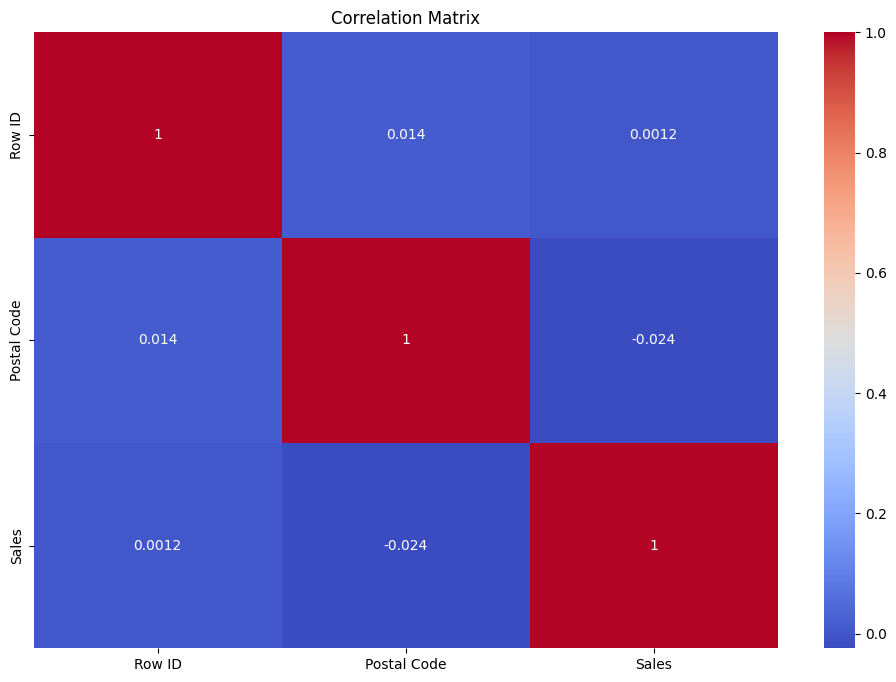

In [3]:
# Display basic statistics
print(df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

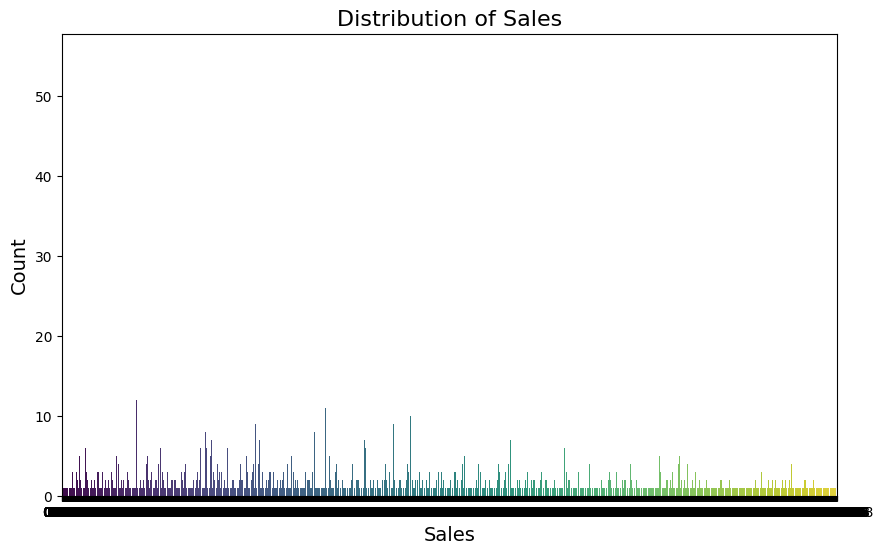

In [4]:
# Distribution of glass types
plt.figure(figsize=(10, 6))
sns.countplot(x='Sales', data=df, palette='viridis')
plt.title('Distribution of Sales', fontsize=16)
plt.xlabel('Sales', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


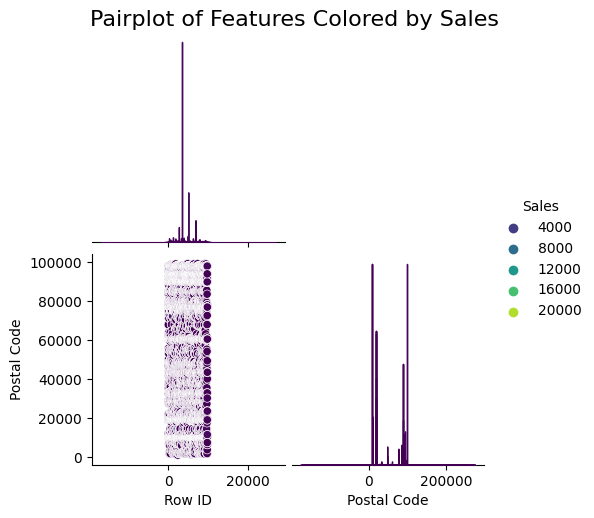

In [5]:
# Pairplot
sns.pairplot(df, hue='Sales', palette='viridis', corner=True)
plt.suptitle('Pairplot of Features Colored by Sales', y=1.02, fontsize=16)
plt.show()

In [6]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d/%m/%Y")
df = df.groupby("Order Date")["Sales"].sum().reset_index()
df = df.sort_values("Order Date")
df

,Order Date,Sales
0,2015-01-03,16.4480
1,2015-01-04,288.0600
2,2015-01-05,19.5360
3,2015-01-06,4407.1000
4,2015-01-07,87.1580
...,...,...
1225,2018-12-26,814.5940
1226,2018-12-27,177.6360
1227,2018-12-28,1657.3508
1228,2018-12-29,2915.5340


In [7]:
# Train-test split
test_size = int(len(df) * 0.2)
train, test = df.iloc[:-test_size].copy(), df.iloc[-test_size:].copy()


In [8]:
# Ensure "Sales" column exists in both train and test sets
if "Sales" not in train.columns or "Sales" not in test.columns:
    raise KeyError("The 'Sales' column is missing from train or test dataset!")

In [9]:
# Define numerical features
numerical_features = ["Sales"]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

In [10]:
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    # Create the model with the suggested hyperparameters
    xgb_regressor = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb_regressor)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, train.drop(columns=['Order Date']), train['Sales'], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    return scores.mean()


In [ ]:
# Check if the hyperparameters are already stored in the JSON file

model_name = 'XGBoost'
json_file = f'{model_name}.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Remove the 'model' key from best_params if it exists
best_params.pop('model', None)

# Create the model with the best hyperparameters
xgb_regressor = XGBRegressor(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_regressor)
])


# Check if the JSON file contains hyperparameters
if 'n_estimators' in best_params:
    # Use the hyperparameters from the JSON file
    xgb_regressor = XGBRegressor(**best_params)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

    # Create the model with the best hyperparameters
    xgb_regressor = XGBRegressor(**best_params)
    

[I 2025-02-25 20:51:14,725] A new study created in memory with name: no-name-5aa48d2d-e601-40ea-8e62-461ea4d03776


Best Hyperparameters: {'model': 'XGBoost'}


[I 2025-02-25 20:51:16,462] Trial 0 finished with value: -44.79498663372651 and parameters: {'n_estimators': 104, 'max_depth': 19, 'learning_rate': 0.1701953145801099, 'subsample': 0.7232957837888969, 'colsample_bytree': 0.6563277388762332}. Best is trial 0 with value: -44.79498663372651.
[I 2025-02-25 20:51:17,430] Trial 1 finished with value: -48.335849114755774 and parameters: {'n_estimators': 312, 'max_depth': 3, 'learning_rate': 0.0725670581924616, 'subsample': 0.9451881063492882, 'colsample_bytree': 0.9420293622358464}. Best is trial 1 with value: -48.335849114755774.
[I 2025-02-25 20:51:18,407] Trial 2 finished with value: -54.169865228341486 and parameters: {'n_estimators': 189, 'max_depth': 3, 'learning_rate': 0.15226665934057673, 'subsample': 0.9376342985012923, 'colsample_bytree': 0.9015382573104173}. Best is trial 2 with value: -54.169865228341486.
[I 2025-02-25 20:51:19,450] Trial 3 finished with value: -49.10544596692301 and parameters: {'n_estimators': 406, 'max_depth': 

In [16]:
# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_regressor)
])

# Define the features and target
X_train = train.drop(columns=['Order Date'])
y_train = train['Sales']

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Sales'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8538076874171308, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=No...ne,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.29540510012721627, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=55, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [17]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.83416703 0.99865197 0.95948211 0.99633194 0.98405124]
Mean cross-validation score: 0.9545368582829246


In [18]:
# Predict on the test data
y_pred = pipeline.predict(test)

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate regression metrics
r2 = r2_score(test['Sales'], y_pred)
mae = mean_absolute_error(test['Sales'], y_pred)
mse = mean_squared_error(test['Sales'], y_pred)
rmse = mean_squared_error(test['Sales'], y_pred, squared=False)

print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R2 Score: 0.9831076289228934
Mean Absolute Error (MAE): 67.16605704376718
Mean Squared Error (MSE): 101625.30466049988
Root Mean Squared Error (RMSE): 318.7872404292554


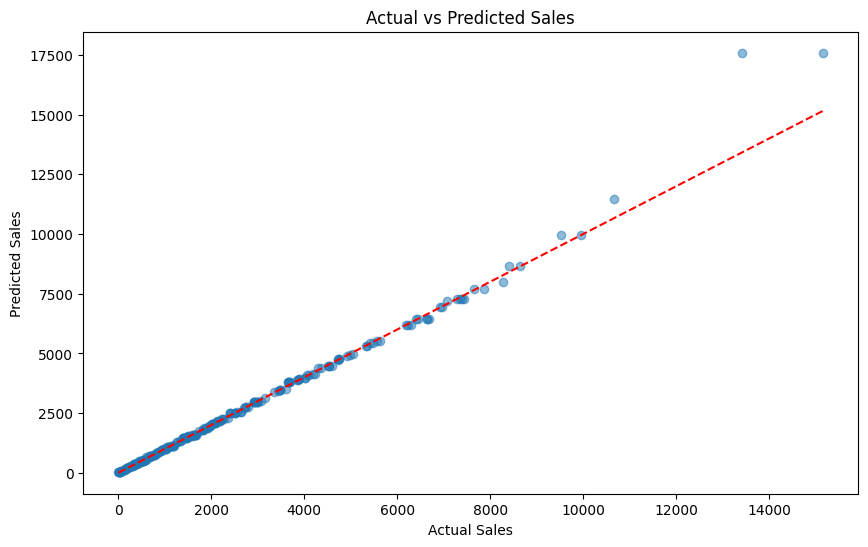

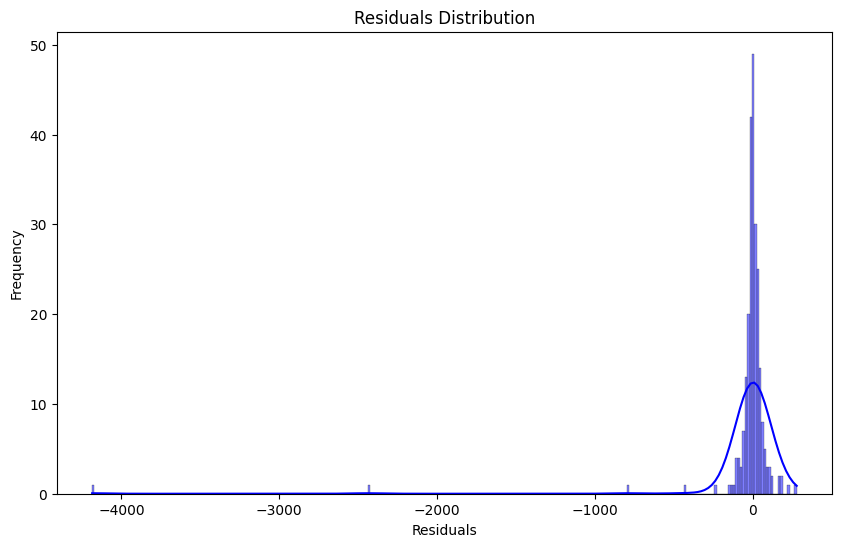

In [23]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test['Sales'], y_pred, alpha=0.5)
plt.plot([test['Sales'].min(), test['Sales'].max()], [test['Sales'].min(), test['Sales'].max()], 'r--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

# Residual plot
residuals = test['Sales'] - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

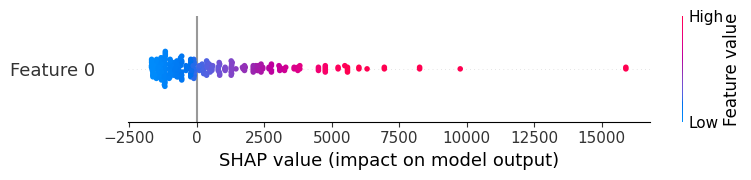

In [25]:
# Define X_test and y_test
X_test = test.drop(columns=['Order Date'])
y_test = test['Sales']

# Transform X_test using the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Calculate SHAP values
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X_test_transformed)

# Explainability using SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed)

In [27]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "R2_Score": r2,
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("xgboost_metrics.csv", index=False)

In [28]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(xgb_regressor, 'xgboost.pkl')

print("Model saved successfully as 'xgboost.pkl'")


Model saved successfully as 'xgboost.pkl'
